# Pulsebuilding Tutorial Flatbean Version
Yet another pulse building library ;-).

This new version of broadbean is a major rebuild, with the main difference that one does not have to define all values directly when building the sequence but can simply provide a placeholder string, a *symbol*, and specify the a list of symbols when the sequence is rendered, or *forged* as it is called here. Furthermore one can also define dependencies of those symbols to create a template with the symbols as the relevant input parameters.

The main structure of a sequence has changed only slightly: A sequence is made up of a list of elements. Each element contains a waveform for each channel. These waveforms are called segments here and can be concatenated via so called group segments. The waveform of a segment is defined by an *atom* the smallest building block of a sequence. An atom simply is a pyhton function that takes time stamps as an t axis as in input plus other parameters to return a numpy array representing the wave form  (i.e. return np.sin(a*t+b)).


This document is a short intro that provides a tour of the central features.

## System Setup
The notebook can either be run with the AWG5014 or standalone such that the output is produced as plots.
We use the `StationConfigurator` to generate an instance of the AWG5014. However all is compatible with other AWGs. Broadbean produces a so called *forged_sequence* as an output, which is a nested list/dictionary representing the complete waveform. So far only the aformentioned AWG supports this format, but others are soon to follow

In the next cell we define the instrument instance and create a virtual instrument so that this notebook can also be used without an AWG at hand. Furthermore we define a function to send and plot the forged sequence.

**you need to have all packages from test_requirements.txt installed**

**For uploading the forged sequences to the AWG5014 you need PR1167**

in principle the operation is also possible with other tektronics awgs, but we changed the format of the forged sequence slightly (List instead of Dictionary). These changes will shortly be incorporated into the drivers.

In [26]:
# change this if you want to use the real awg
real_instrument_present = False

if real_instrument_present:
    from qdev_wrappers.station_configurator import StationConfigurator
    sc = StationConfigurator()
    awg = sc.load_instrument('AWG5014')
else:
    from qcodes.instrument_drivers.tektronix.AWG5014 import Tektronix_AWG5014
    from qcodes import Instrument
    from contextlib import suppress
    import qcodes.instrument.sims as sims
    visalib = sims.__file__.replace('__init__.py', 'Tektronix_AWG5014C.yaml@sim')
    with suppress(KeyError):
        awg_sim = Instrument.find_instrument('awg_sim')
        awg_sim.close()
    awg = Tektronix_AWG5014('awg_sim',
                            address='GPIB0::1::65535::INSTR',
                            timeout=1,
                            terminator='\n',
                            visalib=visalib)

Connected to: QCoDeS AWG5014C (serial:1000, firmware:0.1) in 0.01s


In [27]:
import numpy as np
from broadbean import Segment, SegmentGroup, Element, Sequence
# atoms here are basic functions that create segments
from broadbean.atoms import sine, ramp, flat, zero, marker_on, marker_off
from broadbean.plotting import plotter

def send_and_plot(forged_sequence, SR):
    if real_instrument_present:
        awg.make_send_and_load_awg_file_from_forged_sequence(forged_sequence)
    plotter(forged_sequence, SR=SR)

## Hello World
Lets upload a simple sine wave.

and the actual creation is (almost) self explanatory: (Here the two as the dictionary key stands for the channel two of the used AWG. Later we will be using routing i.e. use abstract names for the channels and route them with a map to the physical channels)

In [28]:
# here sine is a function that creates an object of type `Segment`
seg = sine(duration=1e-3, frequency=1e3)
# create an element with a single segment on channel `2`
e = Element({2:seg})
s = Sequence([e])
fs = s.forge(SR=1e6)

`fs` is the _forged sequece_ and can be passed to the qcodes driver.

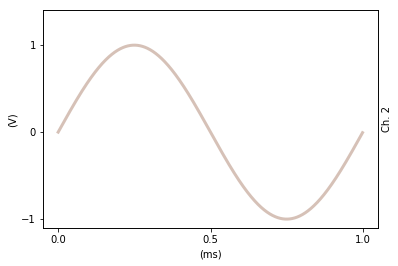

In [29]:
send_and_plot(fs, SR=1e6)

#### behind the scenes
The principle concept is to use standard python containers as much as possible. A Sequence for example, is simply represented by a list of elements `Sequence.elements` (Or possibly a list mixed type with elements and sequences to support subsequences).

Elements are mainly represented by a dictionary `Elements.segments` containing its segments indexed by the respective channel ids/channel names. On top of that there is a dictionary (`Element.sequencing`) containing the sequencing information, like how many times the element should be repeated, jump targets, etc. Elements have an addtional `Element.local_context` and can remember their assigned `Element._transformation`,  which will be explained in the sections 'Transformations' and 'Making Parametric Sequences'.

The function `sine` is a simple convenience wrapper. The first line of this example could be replaced by:
```
# instead of: `seg = sine(duration=1e-3, frequency=1e3)` one can use:
seg = Segment(function='sine', duration=1e-3, frequency=1e3)
```
A `Segment` holds a function and its arguments and a method `Segment.forge` that renders the function, using the arguments, into a numpy array. These functions received the name 'atoms' in the previous version of Broadbean, because they form the smallest building block of a sequence.
An atom is required to take keyword arguments only, one of which is the numpy array `time`, representing the time axis and to return a numpy array of the rendered function. The used example here is defined in 'atoms.py':
```
@atom
def sine(time, frequency, amplitude=1, phase=0):
    return amplitude*np.sin(frequency*2*np.pi*time + phase)
```
The `@atom` decorator simply wrappes the function such that it returns a `Segment` and can be used as in the example.

The idea with the atoms is that there is a uniquely named and version controlled collection, such that an atom name and its parameters will be sufficient meta data to resconstruct the original waveform.



## Segment Groups
If we want to create a segment that is composed by multiple atoms, we need to create a `SegmentGroup`:

In [30]:
# create a square pulse
seg1 = zero(duration=1e-3)
seg2 = flat(duration=1e-3, amplitude=1)
seg3 = zero(duration=1e-3)

pi_pulse = SegmentGroup(seg1, seg2, seg3,
                        duration=3e-3)

In [31]:
# create a square pulse
seg1 = zero(duration=1e-3)
seg2 = flat(duration=1e-3, amplitude=1)
seg3 = zero(duration=1e-3)

pi_pulse = SegmentGroup(seg1, seg2, seg3,
                        duration=3e-3)
fs = Sequence([Element({1:pi_pulse})]).forge(SR=1e6)

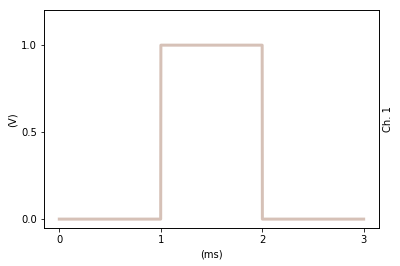

In [32]:
send_and_plot(fs, SR=1e6)

#### behind the scenes
The `SegmentGroup` class inherits like the `Segment` class from a common base class `_BaseSegment`. It simply stores a list `SegmentGroup._segments` of segments and upon forging calls the respective forging function and concatenates the resulting array.

On top of that it also has, just like the Elements, a memory of a 'transformation' that has been supplied upon construction `SegmentGroup._transformation`.

## Symbols
The most significant improvement is that one can define _symbols_. That means we can define a prototype of/recepie for a sequence and parametrize it. A symbol is nothing but a property that has not been given a concrete numeric value but a placeholder for evaluation at forging time. This is simply realized by passing a `str` as the value of a given property
To follow up with the previous example we could specify the amplitude of that pi-pulse:

In [33]:
# create a square pulse
seg1 = zero(duration=1e-3)
seg2 = flat(duration=1e-3, amplitude='pi_amp')
seg3 = zero(duration=1e-3)

pi_pulse = SegmentGroup(seg1, seg2, seg3,
                        duration = 1e3)
s = Sequence([Element({2:pi_pulse})])
# here the sequence s is a recepy for building a pi-pulse for any amplitude
# for getting the actual waveform we need to specify the context and pass it to the forge method
context = {'pi_amp': 0.5}
fs = s.forge(SR=1e6, context=context)

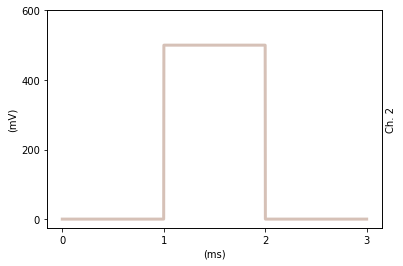

In [34]:
send_and_plot(fs, SR=1e6)

#### behind the scenes
So far the usage of the symbols is not quite clear. We could also imagine to just access the value that we want to change by identifying the element with a name or id and the segment via the channel like so:
```
# sequence(List)->element(Dict)->SegementGroup(List)->segments(Member)->value
s.elements[0].segments[2]._segments[1]._properties['amplitude'] = 0.5
```
But as soon as a vaule gets used in multiple places, one would have to create an additional mapping of where a value needs to be changed. With the symbols we only need to take care of giving unique names and their occurences will be found for us.

The leading priciple is 'late evaluation'. This enables maximum flexibility at the cost of late failure. This means that symbols only become replaced by their values on forging time where errors may occur due to a maldefined sequence. However, Segements and Elements can be forged individually by `Segment.forge` and `Element.forge` when an appropiate context and sample rate is supplied.

## Transformations
In order to make the feature of symbols really useful we need to take into account dependencies of symbols. So for example if we want to tune the pulse duration and keep the overall duration of the element constant.
For this we can introduce a transformation:

In [35]:
seg1 = zero(duration=1e-1)
seg2 = flat(duration='pulse_duration', amplitude=1)
seg3 = zero(duration='flex_time')

def keep_total_duration_constant(context):
    context['flex_time'] = context['total_duration'] - context['pulse_duration'] - 1e-1
                                 

pi_pulse = SegmentGroup(seg1, seg2, seg3,
                        duration = 'total_duration',
                        transformation=keep_total_duration_constant)
s = Sequence([Element({1:pi_pulse})])
# here the sequence s is a recepy for building a pi-pulse for any amplitude
# for getting the actual waveform we need to specify the context and pass it to the forge method
context = {'pulse_duration': 0.5e-1,
           'total_duration': 3e-1}
fs = s.forge(SR=1e6, context=context)

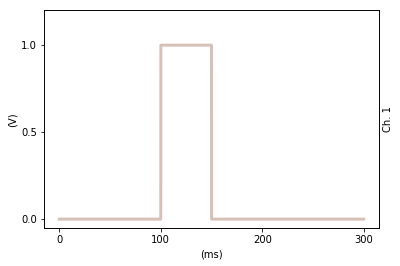

In [36]:
send_and_plot(fs, SR=1e6)

#### behind the scenes
The presented implementation of transformations aims at maximum flexibility at the cost of safety and ease of use. It is meant to be an open interface for higher level abstraction that make their use more convenient. Ideally there will be only transformations that, like the atoms, come from a fixed collection and can thereby be simply included in the metadata.

One example of this would be a linear solver: Here we define a bunch of symbols and their linear dependence in the form of their respective coefficients (clear metadata). The solver needs to know the required symbols (yet to be implemented) and can calculate them from the given context via standard linear algebra methods.

If you can come up with a real world example that does require non-linear coefficients, let us know ;-)

## Making Parametric Sequences
The next logical step is to harness the power of changing symbol values of an element to create a sequence: Here a pulse sequence of centered pulses of increasing length is created.

In [37]:
from broadbean import in_context

seg1 = zero(duration='flex_time')
seg2 = flat(duration='pulse_duration', amplitude=1)
seg3 = zero(duration='flex_time')

# make it centered this time
def keep_total_duration_constant(context):
    context['flex_time'] = 0.5*(context['total_duration'] - context['pulse_duration'])
                                 

pi_pulse = SegmentGroup(seg1, seg2, seg3,
                        duration = 'total_duration',
                        transformation=keep_total_duration_constant)

e = Element({1:pi_pulse})
# `in_context` is a function that simply copies a Segement/Element and assigns a `local_context`
s = Sequence([in_context(e, pulse_duration=t) for t in np.linspace(0.1e-3,1e-3,5)])

# here the sequence s is a recepy for building a pi-pulse for any amplitude
# for getting the actual waveform we need to specify the context and pass it to the forge method
context = {'total_duration': 3e-3}
fs = s.forge(SR=1e6, context=context)

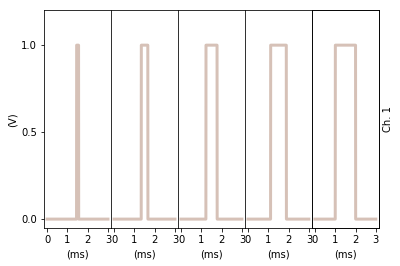

In [38]:
send_and_plot(fs, SR=1e6)

## Adding markers
Markers in this version are treated identical to any other typpe of trace. There are no checks yet if the marker trace is really only 1 or 0.

In [39]:
seg1 = sine(duration='excite_time', phase=np.pi/2, amplitude='amp', frequency=1e3)
# default arguments can be used
seg2 = sine(duration='readout_time', frequency=1e3)

m1 = marker_on(duration='excite_time')
m2 = marker_off(duration='readout_time')

gs = SegmentGroup(seg1, seg2,
                  duration='total_duration')

ms = SegmentGroup(m1, m2,
                  duration='total_duration')

# sequencing information is simply stored as a dict in the elements
e = Element({2:gs,
             '1M1':ms},
            {'nr_rep':2})

s = Sequence([e, e])
times = {'readout_time': 1e-3,
         'excite_time': 2e-3,
        'amp':1}
fs = s.forge(SR=1e6, context=times)

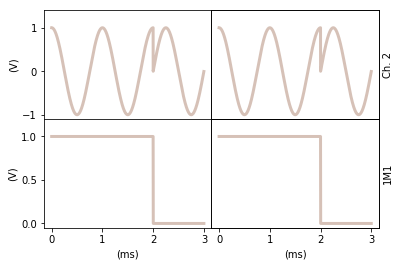

In [40]:
send_and_plot(fs, SR=1e6)

## Routing Signals
The routing module enables to define sequences for abstract channel names and then use a routing dictionary to map those channels to real instrument channels. This seperates the logic of the sequence from the actual wiring. Beyond that one can define sequences that involve multiple instruments.

The following example outputs the marker on a different instrument.

In [41]:
seg1 = sine(duration='excite_time', phase=np.pi/2, amplitude='amp', frequency=1e3)
# default arguments can be used
seg2 = sine(duration='readout_time', frequency=1e3)

m1 = marker_on(duration='excite_time')
m2 = marker_off(duration='readout_time')

gs = SegmentGroup(seg1, seg2,
                  duration='total_duration')

ms = SegmentGroup(m1, m2,
                  duration='total_duration')

e = Element({'MyOutputChannel':gs,
             'MyMarkerChannel':ms},
            {'nr_rep':2})

s = Sequence([e, e])
times = {'readout_time': 1e-3,
         'excite_time': 2e-3,
         'amp': 1}

routing_dict = {'MyOutputChannel': (awg.name, 1),
                'MyMarkerChannel': ('AnotherInstrument', '1M1')}

fs1 = s.forge(SR=1e6,
              context=times,
              routes=routing_dict,
              instrument_name=awg.name)
fs2 = s.forge(SR=1e6,
              context=times,
              routes=routing_dict,
              instrument_name='AnotherInstrument')


# do the same thing for the other instrument
# fs_other = route(fs, routing_dict, ohter_instrument)

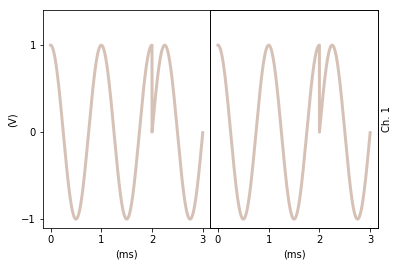

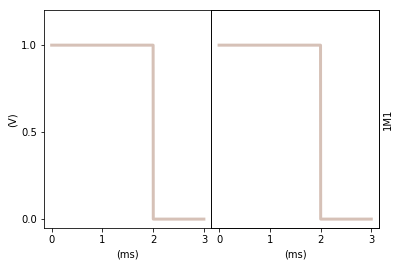

In [42]:
send_and_plot(fs1, SR=1e6)
send_and_plot(fs2, SR=1e6)

## Making Parametric Sequences with transformation on element level
So far we have applied a simple transformation that operates purely on SegmentGroup level. Taking this to the next step includes transformations that act on Element level.

Therefore we consider an example where we add a marker to the flex element with some delay

In [43]:
from broadbean import in_context

seg1 = zero(duration='flex_time')
seg2 = flat(duration='pulse_duration', amplitude=1)
seg3 = zero(duration='flex_time')

pi_pulse = SegmentGroup(seg1, seg2, seg3,
                        duration = 'total_duration')

m1 = marker_off(duration='pre_marker_time')
m2 = marker_on(duration='marker_time')
m3 = marker_off(duration='post_marker_time')

markers = SegmentGroup(m1, m2, m3,
                        duration = 'total_duration')

def mytransformation(context):
    context['flex_time'] = 0.5*(context['total_duration'] - context['pulse_duration'])
    context['pre_marker_time'] = context['flex_time'] + context['marker_delay']
    context['post_marker_time'] = context['total_duration'] - context['marker_time'] - context['pre_marker_time']
                                 

e = Element({1:pi_pulse,
            '1M1':markers},
            transformation=mytransformation)
s = Sequence([in_context(e, pulse_duration=t) for t in np.linspace(0.5e-3,2e-3,5)])

# here the sequence s is a recepy for building a pi-pulse for any amplitude
# for getting the actual waveform we need to specify the context and pass it to the forge method
context = {'total_duration': 3e-3,
          'marker_time': 2e-4,
          'marker_delay':0e-4}
fs = s.forge(SR=1e6, context=context)

It looks like it didn't work correctly but the varying marker delay is an optical illusion

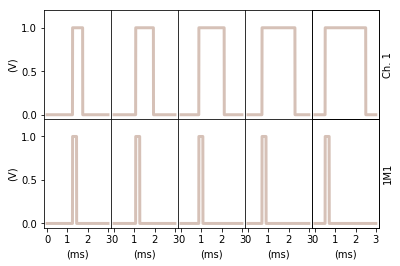

In [44]:
send_and_plot(fs, SR=1e6)

## Serialization
It *should* be possible to serialze the waveforms. This is certainly achievable at the level of the sequence object, when restricting oneself to the used of a defined set of _atoms_. 

It is desirable to have serialization at the highest possible level, i.e. that not the whole forged sequence gets saved but rather the recepie to create it.

One could imagine a simple DSL like yaml that would look like this: (this is not finished yet..., the following format can already be read by the broadbean.laoder module)

In [ ]:
rabi:
    template_element:
        duration: total_duration
        segments:
            main_channel:
                - GroupSegment:  # driving
                    duration: driving_stage_duration
                    segmetns:
                        - sine:
                            duration: ite_time
                            frequency: blah
                - GroupSegment:  # readout
                    duration: readout_stage_duration
                    segmetns:
                        - zero: {duration: readout_delay}
                        - flat: {duration: readout_duration, value=readout_amplitude}
                        - zero: {duration: post_readout_duration}
            alazar_marker:
                - off: {duration=driving_stage_duration}
                - marker_pulse:
                    duration: readout_stage_duration
                    delay: pre_marker_duration
                    marker_duration: readout_marker_duration
        transformation:
            - post_readout_duration:
                - [1, readout_stage_duration]
                - [-1, readout_delay]
                - [-1, readout_duration]
            - pre_marker_duration:
                - [1, readout_delay]
                - [-1, readout_marker_delay]
        local_context:
        sequencing:
    initial_element:


## Forge as meta data only
For the time being the sequences can only be stored as meta data in a clunky way. Instead of rendering the segments out in the form of an np.ndarray, the atom name and the arguments are stored. This requires only a finite amount of memory and enables to reconstruct any sequence. (The reconstruction function does not exist yet)

In [47]:
seg1 = sine(duration='excite_time', phase=np.pi/2, amplitude='amp', frequency=1e3)
seg2 = sine(duration='readout_time', frequency=1e3)
m1 = marker_on(duration='excite_time')
m2 = marker_off(duration='readout_time')
gs = SegmentGroup(seg1, seg2,
                  duration='total_duration')
ms = SegmentGroup(m1, m2,
                  duration='total_duration')
e = Element({2:gs,
             '1M1':ms},
            {'nr_rep':2})

s = Sequence([e, e])
times = {'readout_time': 1e-3,
         'excite_time': 2e-3,
        'amp':1}
fs = s.forge(SR=1e6, context=times, meta_data_only=True)
fs

[{'data': {2: ({'atom': 'sine',
     'args': {'phase': 1.5707963267948966,
      'amplitude': 1,
      'frequency': 1000.0,
      'duration': 0.002}},
    {'atom': 'sine', 'args': {'frequency': 1000.0, 'duration': 0.001}}),
   '1M1': ({'atom': 'marker_on', 'args': {'duration': 0.002}},
    {'atom': 'marker_off', 'args': {'duration': 0.001}})},
  'sequencing': {'nr_rep': 2}},
 {'data': {2: ({'atom': 'sine',
     'args': {'phase': 1.5707963267948966,
      'amplitude': 1,
      'frequency': 1000.0,
      'duration': 0.002}},
    {'atom': 'sine', 'args': {'frequency': 1000.0, 'duration': 0.001}}),
   '1M1': ({'atom': 'marker_on', 'args': {'duration': 0.002}},
    {'atom': 'marker_off', 'args': {'duration': 0.001}})},
  'sequencing': {'nr_rep': 2}}]

## Scoping
Symbol names do not need to be unique. The scoping works from the bottom up:
```
actual_values->transformation->local_context->context from next higher level
```
Lets see how this works with an example:

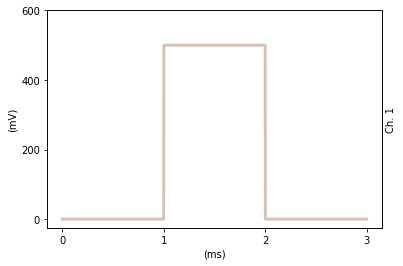

In [48]:
from broadbean.plotting import plotter

seg1 = zero(duration='flex_time')
seg2 = flat(duration='pulse_duration', amplitude='amplitude')
seg3 = zero(duration='flex_time')

pi_pulse = SegmentGroup(seg1, seg2, seg3,
                        duration = 'total_duration')


def mytransformation(context):
    context['flex_time'] = 0.5*(context['total_duration'] - context['pulse_duration'])
                                     

e = Element({1:pi_pulse},
            local_context={'flex_time': 0,
                           'amplitude': 0.5,
                           'pulse_duration': 1e-3},
            transformation=mytransformation)

context = {'total_duration': 3e-3,
           'amplitude': 1,
           'flex_time': 0}
plotter(e, SR=1e6, context=context)

here one can see that the resulting plot has:
- the amplitude as defined in the local context not as in the global context
- the duration as defined in the local context.
- the flex time as resulting of the transformation, not as defined in the local context
- the total duration as defined in the context

This means symbols can be reused and elements etc can be copied:

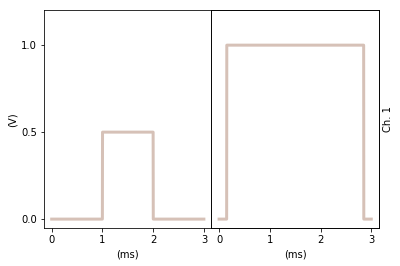

In [49]:
from broadbean.plotting import plotter
from copy import copy

seg1 = zero(duration='flex_time')
seg2 = flat(duration='pulse_duration', amplitude='amplitude')
seg3 = zero(duration='flex_time')

pi_pulse = SegmentGroup(seg1, seg2, seg3,
                        duration = 'total_duration')


def mytransformation(context):
    context['flex_time'] = 0.5*(context['total_duration'] - context['pulse_duration'])
                                     

e = Element({1:pi_pulse},
            local_context={'flex_time': 0,
                           'amplitude': 0.5,
                           'pulse_duration': 1e-3},
            transformation=mytransformation)
e2 = copy(e)
e2.local_context['pulse_duration'] = 2.7e-3
e2.local_context.pop('amplitude')


context = {'total_duration': 3e-3,
           'amplitude': 1,
           'flex_time': 0}
plotter(Sequence([e, e2]), SR=1e6, context=context)

Here the copy can have a changed new local context and the symbol 'flex_time' is only defined in the scope of each element.

## Future Features


This library is still in a beta stage and has many bugs and no validation. Things that are going to change soon are:
- make all objects really stateful (e.g.a copy method for SegmentGroup)
- expose some of the _members so that the objects can be changed (e.g SegmentGroup.segments)
- add local context to GroupSegement
- implement a proper serialization
- provide support for other tektronix awgs
- full support for subsequences